# Model Evaluation

## Load Dataset

In [1]:
import pandas as pd
df = pd.read_csv('../data/precio_mercado_diario.csv', parse_dates=['datetime_utc'], index_col=0)
df = df.loc["2020":].copy()
df

,Mercado SPOT
datetime_utc,
2020-01-01 00:00:00+00:00,38.60
2020-01-01 01:00:00+00:00,36.55
...,...
2023-08-04 20:00:00+00:00,94.00
2023-08-04 21:00:00+00:00,91.70


## Data Preprocessing

In [2]:
### Data Numpy Array
data_array = df.values

### Train Test Split
from sklearn.model_selection import train_test_split
train, test = train_test_split(data_array, test_size=0.2, shuffle=False)

### Create Sequences
import numpy as np
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 24 # Use 24 hours prior to predict the following hour
X_train, y_train = create_sequences(train, sequence_length)
X_test, y_test = create_sequences(test, sequence_length)

## Modelling

### Design NN Architecture

In [3]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input

model = Sequential(layers=[
    Input(shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

/Users/sota/miniconda3/envs/work/lib/python3.12/site-packages/keras/layers/rnn/rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Train Model

In [4]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=3)
history = model.fit(
    X_train, y_train, epochs=50, batch_size=64, verbose=0,
    validation_data=(X_test, y_test), callbacks=[early_stop])

### Calculate Predictions

In [5]:
y_pred = model.predict(X_test)
y_pred


  1/197 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step


 56/197 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step


111/197 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step


169/197 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step


197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


array([[122.53596],
       [ 95.38285],
       [ 83.41055],
       ...,
       [ 99.38489],
       [ 94.59115],
       [ 91.81565]], dtype=float32)

## Comparison: Real Data & Prediction

### Create DataFrame

In [6]:
import sys
sys.path.append('../')

In [7]:
import utils

dic_pred = {
    'y_pred': y_pred
}

df_pred = utils.process_df_pred(df, y_test, dic_pred)
df_pred

/Users/sota/Library/CloudStorage/Dropbox/2 Business/1 Datons/2 Areas/Courses/22 TS/solutions-new/notebooks/60_Forecasting II Deep Learning/3_Model Evaluation/../utils.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index = pd.date_range(start=date_start, end=date_end, freq='H')


,y_true,y_pred
2022-11-15 22:00:00+00:00,105.00,122.535957
2022-11-15 23:00:00+00:00,90.52,95.382851
...,...,...
2023-08-04 20:00:00+00:00,94.00,94.591148
2023-08-04 21:00:00+00:00,91.70,91.815651


### Visualize Data

#### All Hours

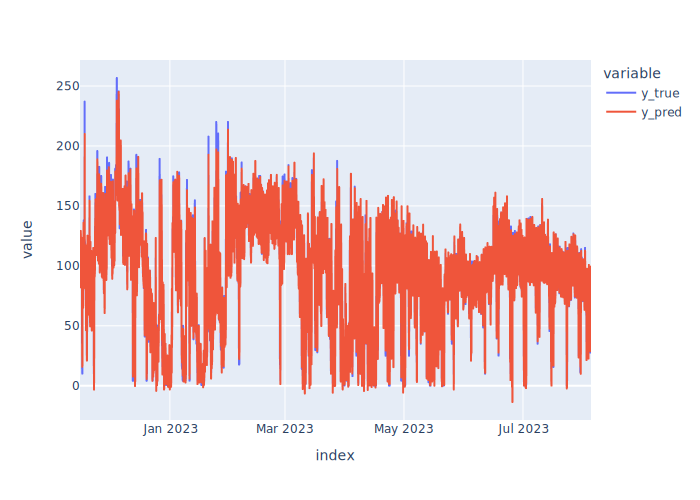

In [8]:
utils.plot_df(df_pred)

#### Last 2 Days

In [9]:
df_pred_2 = df_pred.loc['2023-08-02':].copy()
df_pred_2

,y_true,y_pred
2023-08-02 00:00:00+00:00,96.09,92.463425
2023-08-02 01:00:00+00:00,96.09,93.606354
...,...,...
2023-08-04 20:00:00+00:00,94.00,94.591148
2023-08-04 21:00:00+00:00,91.70,91.815651


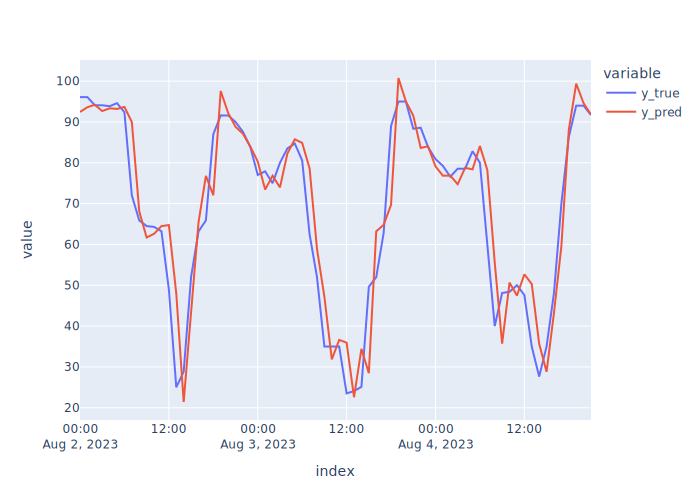

In [10]:
utils.plot_df(df_pred_2)

## Metrics to Measure Model Error

### Mean Squared Error

In [11]:
df_pred['error'] = df_pred.y_true - df_pred.y_pred
df_pred['error2'] = df_pred['error']**2
MSE = df_pred.error2.mean()
MSE

126.77113485183527

### Mean Absolute Error

In [12]:
df_pred['error'] = df_pred.y_true - df_pred.y_pred
df_pred['error_abs'] = df_pred['error'].abs()
MAE = df_pred.error_abs.mean()
MAE

7.371508163532227

### Root Mean Squared Error

In [13]:
RMSE = np.sqrt(MSE)
RMSE

11.259268841795867

### Scikit-Learn Metrics

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_true=df_pred.y_true, y_pred=df_pred.y_pred)
mse = mean_squared_error(y_true=df_pred.y_true, y_pred=df_pred.y_pred)
rmse = mean_squared_error(y_true=df_pred.y_true, y_pred=df_pred.y_pred, squared=False)

/Users/sota/miniconda3/envs/work/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [15]:
mae

7.371508163532227

In [16]:
mse

126.77113485183527

In [17]:
rmse

11.259268841795867